In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import itertools as it

In [143]:
training_data = np.loadtxt('../../NNQuST-master/benchmarks/c++/training_data.txt').astype(np.float32)
target_psi = np.loadtxt('../../NNQuST-master/benchmarks/c++/target_psi.txt').astype(np.float32)
target_psi = tf.reshape(target_psi, shape = [1024, 1])

In [144]:
class RBM:
    
    def __init__(self, train_data_file, num_hidden, num_visible, learning_rate, momentum, batch_size, weights=None, visible_bias=None, hidden_bias=None):
        
        # number of hidden units and visible units
        self.train_data_file = train_data_file
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size # mini batch size for Stoch. grad. desc.
        self.momentum = momentum # TODO: should have momentum and learning rate be variable
                                 # for each epoch. Learning rate should decrease exponentially
                                 # and the momentum should decrease exponentially
            
        # initialize weights, visible bias and hidden bias
        self.weights = tf.Variable(tf.random_normal(shape=(self.num_visible, self.num_hidden), mean = 0.0, 
                                                    stddev = 1.0, dtype = tf.float32, seed = None, name = None), tf.float32) # rows = num_hid, cols = num_vis
        
        #self.weights = tf.get_variable('weights', shape = (self.num_visible, self.num_hidden), initializer = tf.random_normal_initializer)
        
        self.hidden_bias = tf.Variable(tf.random_normal(shape=(self.num_hidden,1)), tf.float32)
        self.visible_bias = tf.Variable(tf.random_normal(shape=(self.num_visible,1)), tf.float32)
        
        # velocities for momentum
        self.weights_vel = tf.Variable(tf.zeros_like(self.weights), dtype = tf.float32)
        self.visible_bias_vel = tf.Variable(tf.zeros_like(self.visible_bias), dtype = tf.float32)
        self.hidden_bias_vel = tf.Variable(tf.zeros_like(self.hidden_bias), dtype = tf.float32)
        
        self._all_hidden_states = None
        self.max_feasible_for_log_pf = 24
        
    @property
    def all_hidden_states(self):
        if self._all_hidden_states is None:
            assert self.num_hidden <= self.max_feasible_for_log_pf, \
                'cannot generate all hidden states for num_hidden > {}'.format(self.max_feasible_for_log_pf)
            self._all_hidden_states = np.array(list(it.product([0, 1], repeat=self.num_hidden)), dtype=np.float32)
        return self._all_hidden_states
    
    # log of partition function - all visibles
    def exact_logZ(self,visible_space):
        free_energy_ = self.free_energy(visible_space)
        logZ = tf.reduce_logsumexp(free_energy_)
        return logZ

    # partition function - all visibles
    def exact_Z(self):
        return tf.exp(self.exact_logZ) # this is Z

    # calculate NLL
    def negative_log_likelihood(self, visible_samples, log_Z):
        free_energy  = tf.matmul(visible_samples, self.visible_bias)
        free_energy += tf.reduce_sum(tf.nn.softplus(tf.matmul(visible_samples, self.weights) 
                                                    + tf.transpose(self.hidden_bias)))
        
        return -tf.reduce_mean(free_energy - log_Z)      

    # juan's code for exact logZ
    def exact_log_partition_function(self):
        with tf.name_scope('exact_log_Z'):
            # Define the exponent: H*b + sum(softplus(1 + exp(a + w*H.T)))
            first_term = tf.matmul(self.all_hidden_states, self.hidden_bias, name='first_term')
            with tf.name_scope('second_term'):
                second_term = tf.matmul(self.weights, self.all_hidden_states, transpose_b=True)
                second_term = tf.nn.softplus(tf.add(self.visible_bias, second_term))
                second_term = tf.transpose(tf.reduce_sum(second_term, reduction_indices=[0], keep_dims=True))
            exponent = tf.cast(first_term + second_term, dtype=tf.float64, name='exponent')
            #exponent_mean = tf.reduce_mean(exponent)
            exponent_mean = tf.reduce_max(exponent)

            return tf.log(tf.reduce_sum(tf.exp(exponent - exponent_mean))) + exponent_mean
    
    def energy(self, hidden_samples, visible_samples):
        return  -tf.matmul(visible_samples, self.visible_bias) \
                - tf.matul(hidden_samples, self.hidden_bias) \
                - tf.reduce_sum(tf.matmul(visible_samples, self.weights) * hidden_samples, 1)

    def prob_hidden_given_visible(self, visible_samples):
        # make sure doing right multiplcation here
        arg = tf.matmul(visible_samples, self.weights) + tf.transpose(self.hidden_bias)
        return tf.nn.sigmoid(arg)

    def prob_visible_give_hidden(self, hidden_samples):
        # make sure doing right multiplcation here
        arg = tf.matmul(hidden_samples, tf.transpose(self.weights)) + tf.transpose(self.visible_bias)
        return tf.nn.sigmoid(arg)

    def sample_hidden_given_visible(self,visible_samples):
        b = tf.shape(visible_samples)[0] # the number of visible samples
        m = self.num_hidden
        samples = self.sample(self.prob_hidden_given_visible(visible_samples), b, m)
        return samples

    def sample_visible_given_hidden(self,hidden_samples):
        b = tf.shape(hidden_samples)[0] # the number of hidden samples
        n = self.num_visible
        samples = self.sample(self.prob_visible_give_hidden(hidden_samples), b, n)
        return samples

    def gibbs_sampling(self, num_iters, v0_samples): # initialize v from a training sample batch, v0 -- matrix of shape 
                                                     # (batch_size=num_rows, shape(training_sata_file)[1])=num_cols)
        h0_samples = self.sample_hidden_given_visible(v0_samples)
        v_samples, h_samples = v0_samples, h0_samples 

        for i in range(num_iters):
            v_samples = self.sample_visible_given_hidden(h_samples)
            h_samples = self.sample_hidden_given_visible(v_samples)

        # spit out original visible and hidden samples, the reconstructed sample and the prob_h_given_v
        return v0_samples, h0_samples, v_samples, self.prob_hidden_given_visible(v_samples)
    
    # gradient of neg. log liklihood
    def grad_NLL_one_batch(self, batch, num_gibbs_iters): # batch: batch of entire training data     
        w_grad  = tf.zeros_like(self.weights)
        vb_grad = tf.zeros_like(self.visible_bias) # vb_grad = (num_vis, 1). hb_grad = (num_hid, 1)
        hb_grad = tf.zeros_like(self.hidden_bias)

        v0, h0, vk, prob_h = self.gibbs_sampling(num_gibbs_iters, batch) # sample batches
        
        print 'h0 dims: ',h0.shape
        print 'prob_h dims:',prob_h

        # v0 and vk should be (batch_size, n_vis)
        # h0 and prob_h should be (batch_size, n_hidden)

        w_grad  += tf.matmul(tf.transpose(v0), h0) 
        w_grad  -= tf.matmul(tf.transpose(vk), prob_h) # this should work

        vb_grad += tf.reduce_sum(v0 - vk) # add each row of v0 and vk
        hb_grad += tf.reduce_sum(h0 - prob_h)
        
        w_grad  /= tf.to_float(tf.shape(batch)[0])
        vb_grad /= tf.to_float(tf.shape(batch)[0])
        hb_grad /= tf.to_float(tf.shape(batch)[0])
        
        return w_grad, vb_grad, hb_grad

    def probability(self, visible_space):
        return tf.exp(self.free_energy(visible_space))  

    def sqrt_probability_vector(self, visible_space):
        return tf.sqrt(self.probability(visible_space))
    
    def overlap(self, target_wavefunction, visible_space):
        overlap_ = tf.matmul(tf.transpose(target_wavefunction), self.sqrt_probability_vector(visible_space))
#        overlap_ /= tf.sqrt(self.exact_Z())
        return overlap_

    def get_batch(self, index):
        batch_start = index*self.batch_size
        batch_end   = batch_start + self.batch_size 
        batch       = self.train_data_file[batch_start:batch_end,:]
        return batch
    
    def learn(self, visible_samples, num_gibbs_iters): # learning algorithm
        # calculate gradients for a batch
        weight_grad, visible_bias_grad, hidden_bias_grad = self.grad_NLL_one_batch(visible_samples, num_gibbs_iters)

        print 'Weight grad has shape: ',weight_grad.shape
        print 'Vis bias grad has shape: ',visible_bias_grad.shape
        print 'Hid bias grad has shape: ',hidden_bias_grad.shape,'\n'

        # update velocities for momentum
        new_weights_vel      = self.momentum*self.weights_vel + self.learning_rate*weight_grad
        new_visible_bias_vel = self.momentum*self.visible_bias_vel + self.learning_rate*visible_bias_grad
        new_hidden_bias_vel  = self.momentum*self.hidden_bias + self.learning_rate*hidden_bias_grad

        print 'Weight vel has shape: ',new_weights_vel.shape
        print 'Vis bias vel has shape: ',new_visible_bias_vel.shape
        print 'Hid bias vel has shape: ',new_hidden_bias_vel.shape,'\n'

        # update weights and biases 
        update_weights        = tf.assign(self.weights, self.weights + new_weights_vel)
        update_visible_biases = tf.assign(self.visible_bias, self.visible_bias + new_visible_bias_vel)
        update_hidden_biases  = tf.assign(self.hidden_bias, self.hidden_bias + new_hidden_bias_vel)

        # update velocities
        update_weights_vel      = tf.assign(self.weights_vel, new_weights_vel)
        update_visible_bias_vel = tf.assign(self.visible_bias_vel, new_visible_bias_vel)
        update_hidden_bias_vel  = tf.assign(self.hidden_bias_vel, new_hidden_bias_vel)

        return [update_weights, update_visible_biases, update_hidden_biases, 
                update_weights_vel, update_visible_bias_vel, update_hidden_bias_vel]

    @staticmethod
    def sample(probs, m, n):
        return tf.where(
            tf.less(tf.random_uniform(shape=(m,n)), probs),
            tf.ones(shape=(m,n)),
            tf.zeros(shape=(m,n))
        )

    @staticmethod
    def generate_all_possible_visibles(Nspins): # generate all configurations of 0 and 1 for 10 spins
        vis_space = np.zeros((2**Nspins, Nspins)).astype(np.float32)

        for i in range(2**Nspins): # rows  
            temp = i
            for j in range(Nspins): # columns
                temp, remainder = divmod(temp, 2)
                vis_space[i, j] = remainder 

        return vis_space

In [145]:
class Placeholders(object):
    pass

placeholders = Placeholders()

# placeholder for training data
# placeholders.visible_samples = tf.placeholder(tf.float32, shape=(None, num_visible), name = 'v')

# initialize rbm and compute log(Z) for NLL_list

def train(training_data, num_epochs):
    
    weights=None
    visible_bias=None
    hidden_bias=None
    
    num_hidden      = 10
    learning_rate   = 0.001
    num_visible     = training_data.shape[1]
    momentum        = 1.
    num_epochs      = 100
    batch_size      = 100
    num_batches     = training_data.shape[0]/batch_size
    num_gibbs_iters = 1
    epoch_list      = range(1,num_epochs+1)
    
    visible_samples = tf.placeholder(tf.float32, shape=(None,num_visible))
    
    rbm               = RBM(training_data, num_hidden, num_visible, learning_rate, momentum, batch_size, weights = weights, visible_bias = visible_bias, hidden_bias = hidden_bias)
    vis_space         = rbm.generate_all_possible_visibles(num_visible)
    logZ              = rbm.exact_log_partition_function()
    placeholders.logZ = tf.placeholder(tf.float32)
    NLL               = rbm.negative_log_likelihood(visible_samples, placeholders.logZ)
    
    learn_a_batch = rbm.learn(visible_samples, num_gibbs_iters)
        
    with tf.Session() as sess:
        NLL_list    = []
        mean_cost   = []
        batch_count = 0
        epoch       = 1
        init        = tf.global_variables_initializer()
        
        sess.run(init)
        for i in range(num_epochs*num_batches):
            # reset the batch_count and mean cost after we've gone through the entire data set 
            # reshuffle the training data as well
            if batch_count*batch_size + batch_size >= training_data.shape[0]:
                print('Epoch: %d, NLL >>> %g' % (epoch, np.mean(mean_cost)))
                NLL_list.append(np.mean(mean_cost))
                mean_cost   = []
                epoch      += 1
                batch_count = 0
                tf.random_shuffle(training_data)
            
            new_batch = rbm.get_batch(batch_count)           
            print 'Weights: ',sess.run(rbm.weights_vel),'\n'
            sess.run(learn_a_batch, feed_dict = {visible_samples: new_batch})
            lz  = sess.run(logZ)
            nll = sess.run(NLL, feed_dict = {visible_samples: new_batch, placeholders.logZ: lz})
            mean_cost.append(nll)
            
            batch_count += 1
            
    return NLL_list, epoch_list

In [146]:
NLL_list, epoch_list = train(training_data, num_epochs)
print NLL_list
#print overlap_list

h0 dims:  (?, 10)
prob_h dims: Tensor("Sigmoid_187:0", shape=(?, 10), dtype=float32)
Weight grad has shape:  (10, 10)
Vis bias grad has shape:  (10, 1)
Hid bias grad has shape:  (10, 1) 

Weight vel has shape:  (10, 10)
Vis bias vel has shape:  (10, 1)
Hid bias vel has shape:  (10, 1) 

Weights:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 

Weights:  [[-2.18163230e-04 -4.56317473e-04 -3.81758000e-04 -3.67363013e-04
  -4.59184957e-04 -1.70791827e-04 -4.61257267e-04 -7.55549991e-05
  -1.37266892e-04 -3.88684712e-04]
 [-1.04897117e-05  1.09910608e-04  1.69912222e-04 -3.57351128e-05
   1.52969660e-04  5.06796860e-05  1.27869804e-04  3.41519481e-05
   7.57286543e-05  5.84617665e-05]
 [-2.80717686e-05 -9.0959

Weights:  [[-9.73367249e-04 -2.00795829e-02 -1.99501924e-02 -1.35065929e-03
  -2.01256052e-02 -1.96441971e-02 -2.01442018e-02 -1.52514142e-04
  -1.85874625e-04 -5.04738418e-04]
 [ 6.59752868e-06  1.14298165e-02  1.15095368e-02 -1.52030872e-04
   1.15042776e-02  1.10568395e-02  1.14324205e-02  3.00389365e-05
   1.04259918e-04  6.25145331e-05]
 [ 5.70877892e-05 -1.03262399e-04 -3.50397604e-05 -4.62485157e-04
  -4.83162294e-05 -2.88658048e-04 -1.68503437e-04 -3.86196043e-05
   4.12407717e-05 -1.67354388e-04]
 [-6.75258576e-04 -4.47376352e-03 -4.35409509e-03 -7.46346544e-04
  -4.44902247e-03 -4.40340117e-03 -4.61276248e-03 -8.84221445e-05
  -1.14148701e-04 -2.40714900e-04]
 [ 3.40955812e-05  1.36284472e-03  1.40200590e-03 -3.64369771e-04
   1.37138250e-03  1.17405667e-03  1.26592314e-03  2.29022116e-05
  -5.21832735e-05 -6.92808680e-06]
 [-6.43360603e-04 -5.28483465e-03 -5.20259794e-03 -8.10792728e-04
  -5.29933954e-03 -5.11337537e-03 -5.42776519e-03 -9.43215564e-05
  -7.35980502e-05 -3.00

Weights:  [[-9.7336725e-04 -5.2695852e-03 -5.1401947e-03 -1.3506593e-03
  -5.3156074e-03 -4.8341984e-03 -5.3342041e-03 -1.5251414e-04
  -1.8587463e-04 -5.0473842e-04]
 [ 6.5975287e-06  4.8098168e-03  4.8895362e-03 -1.5203087e-04
   4.8842779e-03  4.4368389e-03  4.8124208e-03  3.0038937e-05
   1.0425992e-04  6.2514533e-05]
 [ 5.7087789e-05  4.0267385e-03  4.0949616e-03 -4.6248516e-04
   4.0816846e-03  3.8413429e-03  3.9614975e-03 -3.8619604e-05
   4.1240772e-05 -1.6735439e-04]
 [-6.7525858e-04  5.0662369e-03  5.1859054e-03 -7.4634654e-04
   5.0909780e-03  5.1365993e-03  4.9272380e-03 -8.8422144e-05
  -1.1414870e-04 -2.4071490e-04]
 [ 3.4095581e-05  3.5428447e-03  3.5820056e-03 -3.6436977e-04
   3.5513821e-03  3.3540563e-03  3.4459229e-03  2.2902212e-05
  -5.2183274e-05 -6.9280868e-06]
 [-6.4336060e-04  4.6651666e-03  4.7474033e-03 -8.1079273e-04
   4.6506622e-03  4.8366259e-03  4.5222365e-03 -9.4321556e-05
  -7.3598050e-05 -3.0004050e-04]
 [-8.5983297e-04  2.8810278e-03  3.0146735e-03 -

Weights:  [[-9.73367249e-04  1.24104153e-02  1.25398058e-02 -1.35065929e-03
   1.23643931e-02  1.28458021e-02  1.23457965e-02 -1.52514142e-04
  -1.85874625e-04 -5.04738418e-04]
 [ 6.59752868e-06 -1.54601829e-02 -1.53804636e-02 -1.52030872e-04
  -1.53857218e-02 -1.58331618e-02 -1.54575789e-02  3.00389365e-05
   1.04259918e-04  6.25145331e-05]
 [ 5.70877892e-05 -8.89326353e-03 -8.82504042e-03 -4.62485157e-04
  -8.83831736e-03 -9.07865912e-03 -8.95850454e-03 -3.86196043e-05
   4.12407717e-05 -1.67354388e-04]
 [-6.75258576e-04 -4.05376405e-03 -3.93409515e-03 -7.46346544e-04
  -4.02902300e-03 -3.98340169e-03 -4.19276301e-03 -8.84221445e-05
  -1.14148701e-04 -2.40714900e-04]
 [ 3.40955812e-05 -9.23715625e-03 -9.19799414e-03 -3.64369771e-04
  -9.22861882e-03 -9.42594465e-03 -9.33407899e-03  2.29022116e-05
  -5.21832735e-05 -6.92808680e-06]
 [-6.43360603e-04 -3.83483293e-03 -3.75259621e-03 -8.10792728e-04
  -3.84933734e-03 -3.66337365e-03 -3.97776300e-03 -9.43215564e-05
  -7.35980502e-05 -3.00

Weights:  [[-9.7336725e-04  1.3380413e-02  1.3509806e-02 -1.3506593e-03
   1.3334391e-02  1.3815802e-02  1.3315794e-02 -1.5251414e-04
  -1.8587463e-04 -5.0473842e-04]
 [ 6.5975287e-06 -3.0401845e-03 -2.9604651e-03 -1.5203087e-04
  -2.9657234e-03 -3.4131624e-03 -3.0375805e-03  3.0038937e-05
   1.0425992e-04  6.2514533e-05]
 [ 5.7087789e-05  4.7067381e-03  4.7749616e-03 -4.6248516e-04
   4.7616842e-03  4.5213425e-03  4.6414970e-03 -3.8619604e-05
   4.1240772e-05 -1.6735439e-04]
 [-6.7525858e-04  3.5462361e-03  3.6659050e-03 -7.4634654e-04
   3.5709771e-03  3.6165984e-03  3.4072371e-03 -8.8422144e-05
  -1.1414870e-04 -2.4071490e-04]
 [ 3.4095581e-05  4.3728445e-03  4.4120066e-03 -3.6436977e-04
   4.3813819e-03  4.1840561e-03  4.2759217e-03  2.2902212e-05
  -5.2183274e-05 -6.9280868e-06]
 [-6.4336060e-04  3.7951667e-03  3.8774034e-03 -8.1079273e-04
   3.7806623e-03  3.9666258e-03  3.6522367e-03 -9.4321556e-05
  -7.3598050e-05 -3.0004050e-04]
 [-8.5983297e-04  2.7410269e-03  2.8746726e-03 -

Weights:  [[-9.7336725e-04  3.4304138e-03  3.5598062e-03 -1.3506593e-03
   3.3843915e-03  3.8658015e-03  3.3657949e-03 -1.5251414e-04
  -1.8587463e-04 -5.0473842e-04]
 [ 6.5975287e-06  4.7798161e-03  4.8595355e-03 -1.5203087e-04
   4.8542772e-03  4.4068377e-03  4.7824201e-03  3.0038937e-05
   1.0425992e-04  6.2514533e-05]
 [ 5.7087789e-05  6.8567386e-03  6.9249622e-03 -4.6248516e-04
   6.9116848e-03  6.6713430e-03  6.7914976e-03 -3.8619604e-05
   4.1240772e-05 -1.6735439e-04]
 [-6.7525858e-04  2.1462364e-03  2.2659053e-03 -7.4634654e-04
   2.1709769e-03  2.2165983e-03  2.0072374e-03 -8.8422144e-05
  -1.1414870e-04 -2.4071490e-04]
 [ 3.4095581e-05  6.8828445e-03  6.9220066e-03 -3.6436977e-04
   6.8913819e-03  6.6940561e-03  6.7859218e-03  2.2902212e-05
  -5.2183274e-05 -6.9280868e-06]
 [-6.4336060e-04  2.5151677e-03  2.5974044e-03 -8.1079273e-04
   2.5006628e-03  2.6866265e-03  2.3722372e-03 -9.4321556e-05
  -7.3598050e-05 -3.0004050e-04]
 [-8.5983297e-04 -3.5289733e-03 -3.3953276e-03 -

Weights:  [[-9.73367249e-04 -1.60295889e-02 -1.59001946e-02 -1.35065929e-03
  -1.60756111e-02 -1.55942002e-02 -1.60942078e-02 -1.52514142e-04
  -1.85874625e-04 -5.04738418e-04]
 [ 6.59752868e-06  1.01898182e-02  1.02695385e-02 -1.52030872e-04
   1.02642803e-02  9.81683936e-03  1.01924222e-02  3.00389365e-05
   1.04259918e-04  6.25145331e-05]
 [ 5.70877892e-05 -1.39326276e-03 -1.32503884e-03 -4.62485157e-04
  -1.33831624e-03 -1.57865835e-03 -1.45850389e-03 -3.86196043e-05
   4.12407717e-05 -1.67354388e-04]
 [-6.75258576e-04 -5.58376312e-03 -5.46409469e-03 -7.46346544e-04
  -5.55902300e-03 -5.51340170e-03 -5.72276255e-03 -8.84221445e-05
  -1.14148701e-04 -2.40714900e-04]
 [ 3.40955812e-05 -6.57157041e-04 -6.17994927e-04 -3.64369771e-04
  -6.48619607e-04 -8.45945440e-04 -7.54079781e-04  2.29022116e-05
  -5.21832735e-05 -6.92808680e-06]
 [-6.43360603e-04 -5.63483220e-03 -5.55259548e-03 -8.10792728e-04
  -5.64933708e-03 -5.46337338e-03 -5.77776274e-03 -9.43215564e-05
  -7.35980502e-05 -3.00

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (100,) and (37,)

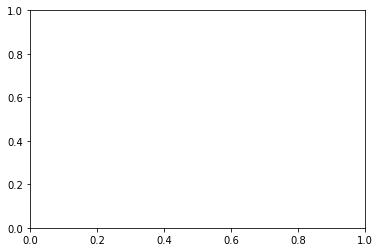

In [79]:
plt.plot(epoch_list, NLL_list)
plt.show()